In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import tree

from IPython.display import SVG
from  graphviz import Source
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from IPython.display import HTML
style = '<style>svg{width:70% !important;height:70% !important;}</style>'

HTML(style)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score,roc_curve, auc

sns.set(rc={'figure.figsize':(15,6)})

In [3]:
sns.set(rc={'figure.figsize':(15,6)})

In [4]:
event_data=pd.read_csv('data\event_data_train.csv')
submissions_data=pd.read_csv('data\submissions_data_train.csv')

event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
event_data['date']=pd.to_datetime(event_data.timestamp, unit='s')
submissions_data['date']=pd.to_datetime(submissions_data.timestamp, unit='s')
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [8]:
event_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [9]:
%%time
max(event_data.date)

Wall time: 3.45 s


Timestamp('2018-05-19 23:33:31')

In [10]:
len(event_data)

3480703

In [11]:
event_data['day']=event_data.date.dt.date
submissions_data['day']=submissions_data.date.dt.date

In [12]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [13]:
event_data.action.value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

In [14]:
event_data.groupby('day').user_id.nunique()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
             ... 
2018-05-15    145
2018-05-16    155
2018-05-17    165
2018-05-18    126
2018-05-19    131
Name: user_id, Length: 1070, dtype: int64

<AxesSubplot:xlabel='day'>

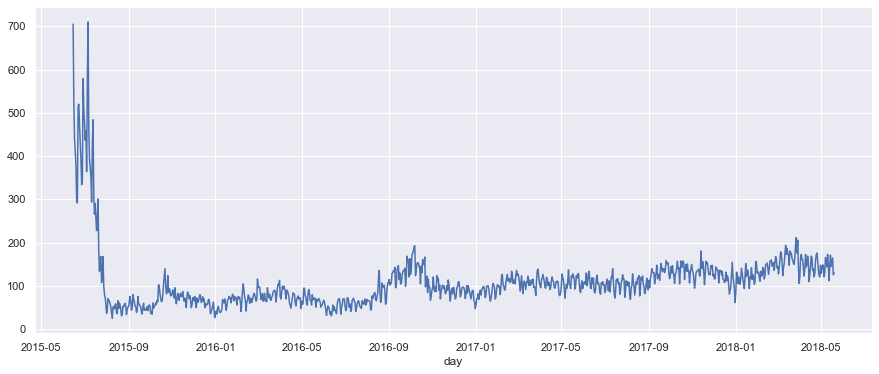

In [15]:
event_data.groupby('day').user_id.nunique().plot()

In [16]:
'''event_data[event_data.action=='passed']\
.groupby('user_id' , as_index=False)\
.agg({'step_id': 'count'}).head()\
.rename(columns={'step_id':'passed_steps'})'''

"event_data[event_data.action=='passed'].groupby('user_id' , as_index=False).agg({'step_id': 'count'}).head().rename(columns={'step_id':'passed_steps'})"

In [17]:
'''event_data[event_data.action=='passed']\
.groupby('user_id' , as_index=False)\
.agg({'step_id': 'count'})\
.rename(columns={'step_id':'passed_steps'})\
.passed_steps.hist()'''

"event_data[event_data.action=='passed'].groupby('user_id' , as_index=False).agg({'step_id': 'count'}).rename(columns={'step_id':'passed_steps'}).passed_steps.hist()"

In [18]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [19]:
event_data.pivot_table(index='user_id'
                       , columns='action'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

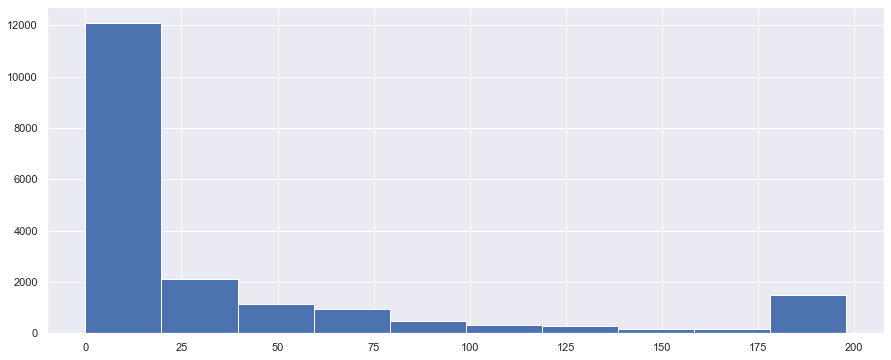

In [20]:
event_data.pivot_table(index='user_id'
                       , columns='action'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index().discovered.hist()

In [21]:
event_data_last=event_data

In [22]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [23]:
users_events_data=event_data.pivot_table(index='user_id'
                       , columns='action'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index()#.discovered.hist()

users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [24]:
users_scores=submissions_data.pivot_table(index='user_id'
                       , columns='submission_status'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index()#.discovered.hist()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [25]:
gap_data=event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [26]:
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int32)], dtype=object)

In [27]:
gap_data=pd.Series(np.concatenate(gap_data, axis=0))


In [28]:
gap_data=gap_data/(24*60*60)

In [29]:
gap_data.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

<AxesSubplot:>

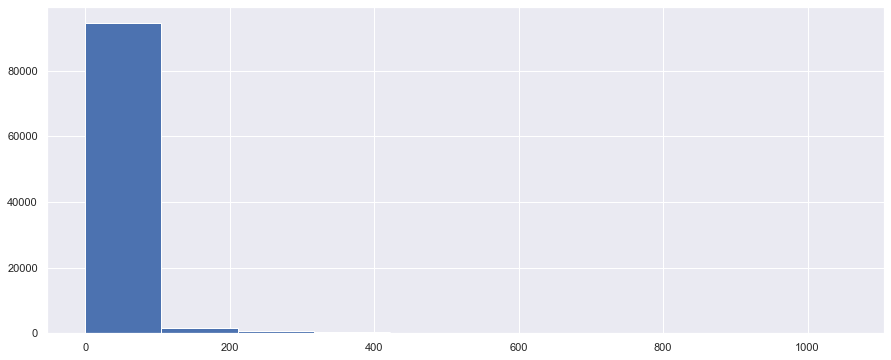

In [30]:
gap_data.hist()

<AxesSubplot:>

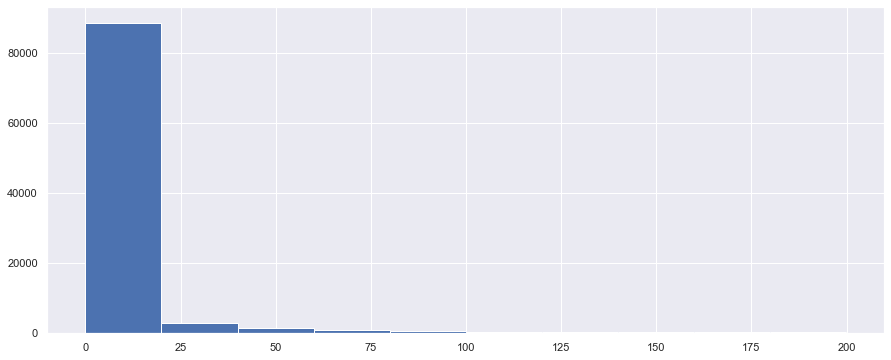

In [31]:
gap_data[gap_data<200].hist()

In [32]:
gap_data.quantile(0.95)

59.760440972222156

In [33]:
users_scores.query('correct == correct.max()')

submission_status,user_id,correct,wrong
439,1046,421,513


In [34]:
users_data= event_data.groupby(
'user_id', as_index=False
).agg({'timestamp': 'max'}).rename(columns={'timestamp':'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [35]:
users_data.tail()

,user_id,last_timestamp
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096
19233,26798,1520978742


In [36]:
now=users_data.last_timestamp.max()

In [37]:
users_data.user_id.max()

26798

In [38]:
drop_out_treshold=30*24*60*60
drop_out_treshold

2592000

In [39]:
users_data['is_gone_user']=now-users_data.last_timestamp>drop_out_treshold

In [40]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [41]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [42]:
users_data.merge(users_scores,on='user_id', how='outer').fillna(0)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [43]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [44]:
users_days=event_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [45]:
users_data=users_data.merge(users_events_data, how='outer')
users_data

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed
0,1,1472827464,True,1,0,0,1
1,2,1519226966,True,9,9,2,10
2,3,1444581588,True,91,87,30,192
3,5,1499859939,True,11,11,4,12
4,7,1521634660,True,1,1,0,1
...,...,...,...,...,...,...,...
19229,26790,1517495987,True,8,8,1,9
19230,26793,1510225034,True,1,0,1,1
19231,26794,1512035039,True,69,69,34,180
19232,26797,1509995096,True,10,10,2,13


In [46]:
users_data=users_data.merge(users_days, how='outer')
users_data

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,1,0,0,1,1
1,2,1519226966,True,9,9,2,10,2
2,3,1444581588,True,91,87,30,192,7
3,5,1499859939,True,11,11,4,12,2
4,7,1521634660,True,1,1,0,1,1
...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,8,8,1,9,4
19230,26793,1510225034,True,1,0,1,1,1
19231,26794,1512035039,True,69,69,34,180,9
19232,26797,1509995096,True,10,10,2,13,2


In [47]:
event_data.user_id.nunique()

19234

In [48]:
users_data.user_id.nunique()

19234

In [49]:
users_data['passed_course']=users_data.passed>170
users_data

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,1,0,0,1,1,False
1,2,1519226966,True,9,9,2,10,2,False
2,3,1444581588,True,91,87,30,192,7,False
3,5,1499859939,True,11,11,4,12,2,False
4,7,1521634660,True,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,8,8,1,9,4,False
19230,26793,1510225034,True,1,0,1,1,1,False
19231,26794,1512035039,True,69,69,34,180,9,False
19232,26797,1509995096,True,10,10,2,13,2,False


In [50]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425


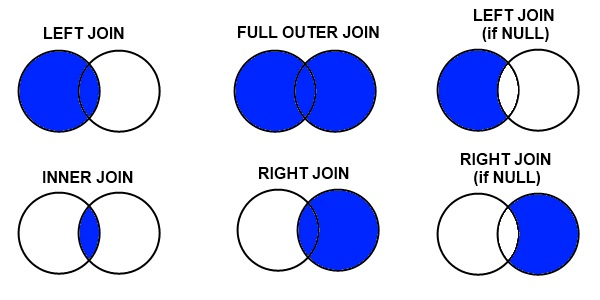

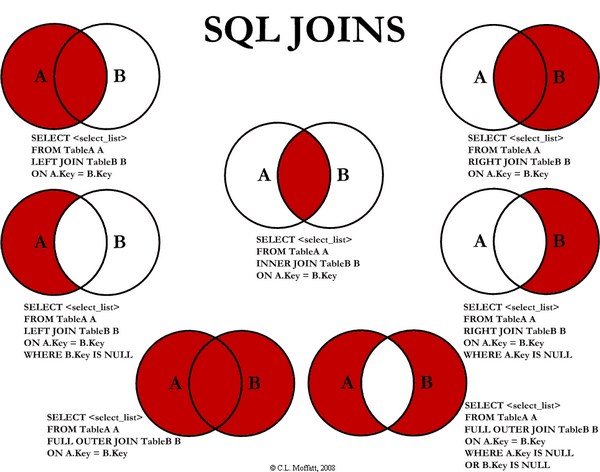

In [51]:
users_data.head()

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,1,0,0,1,1,False
1,2,1519226966,True,9,9,2,10,2,False
2,3,1444581588,True,91,87,30,192,7,False
3,5,1499859939,True,11,11,4,12,2,False
4,7,1521634660,True,1,1,0,1,1,False


In [52]:
users_data[users_data.passed_course].day.median()

20.0

<AxesSubplot:>

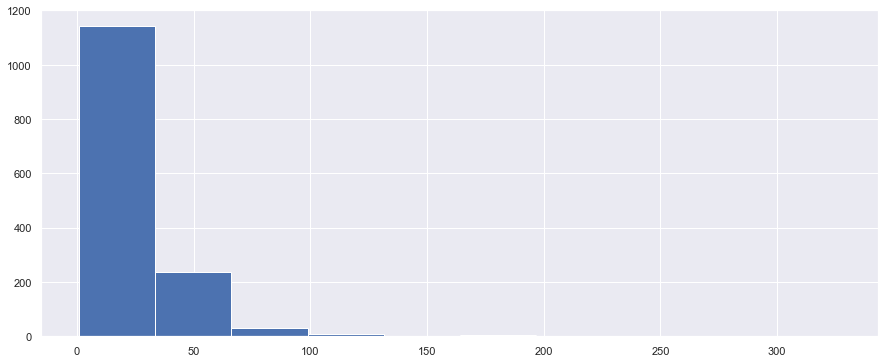

In [53]:
users_data[users_data.passed_course].day.hist()

In [54]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [55]:
user_min_time=event_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'})\
    .rename({'timestamp':'min_timestamp'}, axis=1)

In [56]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [57]:
users_data=users_data.merge(user_min_time, how='outer')

users_data.head()

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,1,0,0,1,1,False,1472827464
1,2,1519226966,True,9,9,2,10,2,False,1514383364
2,3,1444581588,True,91,87,30,192,7,False,1434358476
3,5,1499859939,True,11,11,4,12,2,False,1466156809
4,7,1521634660,True,1,1,0,1,1,False,1521634660


In [58]:
event_data_train=pd.DataFrame()


In [59]:
%%time
'''for user_id in users_data.user_id:
    min_user_time=users_data[users_data.user_id==user_id].min_timestamp.item()
    time_threshold=3*24*60*60
    
    user_events_data=event_data[(event_data.user_id==user_id)&(event_data.timestamp<time_threshold)]
    event_data_train=event_data_train.append(user_events_data)'''

Wall time: 0 ns


'for user_id in users_data.user_id:\n    min_user_time=users_data[users_data.user_id==user_id].min_timestamp.item()\n    time_threshold=3*24*60*60\n    \n    user_events_data=event_data[(event_data.user_id==user_id)&(event_data.timestamp<time_threshold)]\n    event_data_train=event_data_train.append(user_events_data)'

In [60]:
event_data['user_time']=event_data.user_id.map(str) + event_data.timestamp.map(str)

In [61]:
learning_time_threshold=3*24*60*60


In [62]:
user_learning_time_threshold = user_min_time.user_id.map(str)+ '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [63]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [64]:
user_min_time['user_learning_time_threshold']=user_learning_time_threshold

In [65]:
event_data=event_data.merge(user_min_time[['user_id','user_learning_time_threshold']], how='outer')

In [66]:
event_data.shape

(3480703, 8)

In [67]:
event_data_train=event_data[event_data.user_time<=event_data.user_learning_time_threshold ]

In [68]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,176321434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,176321434340895,17632_1434600048


In [69]:
data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
data[data.submission_status == "wrong"].groupby(['user_id', 'step_id'], as_index=False).agg({'timestamp':'max'}).step_id.value_counts().keys()[0]



31978

In [70]:
#event_data_last=event_data
event_data_last.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,176321434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,176321434340895


In [71]:
#event_data_last=pd.read_csv('data\event_data_train.csv')
event_data_last.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,176321434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,176321434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,176321434340895


In [72]:
event_data_last.shape

(3480703, 7)

In [73]:
event_data_last_cut=event_data_last
event_data_last_cut=event_data_last_cut[['step_id', 'timestamp','user_id']]
event_data_last_cut.head()

,step_id,timestamp,user_id
0,32815,1434340848,17632
1,32815,1434340848,17632
2,32815,1434340848,17632
3,32811,1434340895,17632
4,32811,1434340895,17632


In [74]:
event_data_last_cut.shape

(3480703, 3)

In [75]:
step=event_data_last_cut.groupby(['user_id','step_id'])
step.head(10)

,step_id,timestamp,user_id
0,32815,1434340848,17632
1,32815,1434340848,17632
2,32815,1434340848,17632
3,32811,1434340895,17632
4,32811,1434340895,17632
...,...,...,...
3480698,33375,1526772685,11677
3480699,32815,1526772750,5198
3480700,32815,1526772750,5198
3480701,32815,1526772750,5198


In [76]:

event_data_last_cut.shape

(3480703, 3)

In [77]:
event_data_last_cut.head(10)

,step_id,timestamp,user_id
0,32815,1434340848,17632
1,32815,1434340848,17632
2,32815,1434340848,17632
3,32811,1434340895,17632
4,32811,1434340895,17632
5,32811,1434340895,17632
6,32929,1434340921,17632
7,32929,1434340921,17632
8,32929,1434340939,17632
9,32929,1434340944,17632


In [78]:
event_data_last.groupby(pd.Grouper(key="user_id")).mean()

,step_id,timestamp
user_id,,
17632,33105.809681,1.437042e+09
12494,32548.106667,1.435747e+09
442,32905.400673,1.440338e+09
22254,32293.416667,1.434928e+09
6646,33123.294335,1.437273e+09
...,...,...
795,33119.313725,1.526759e+09
13475,32408.923077,1.526760e+09
22851,32927.000000,1.526763e+09


In [79]:
event_data_last.groupby(['step_id'], as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).head()


,step_id,user_id
60,32927,60553
58,32815,51189
64,32950,50847
56,32812,48570
61,32929,46478


In [80]:
df = pd.DataFrame({'consumption': [10.51, 103.11, 55.48],
                   'co2_emissions': [37.2, 19.66, 1712]},
                   index=['Pork', 'Wheat Products', 'Beef'])
df.idxmax()

consumption      Wheat Products
co2_emissions              Beef
dtype: object

In [81]:
event_data_last.columns

Index(['step_id', 'timestamp', 'action', 'user_id', 'date', 'day',
       'user_time'],
      dtype='object')

In [82]:
event_data_last.shape

(3480703, 7)

In [83]:
%%time
grouped=event_data_last.groupby('user_id')['timestamp'].idxmax()
grouped.shape

Wall time: 1.12 s


(19234,)

In [84]:
last_steps=event_data_last.loc[event_data_last.groupby('user_id')['timestamp'].idxmax()]
last_steps.head()

,step_id,timestamp,action,user_id,date,day,user_time
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,11472827464
3073427,32927,1519226966,viewed,2,2018-02-21 15:29:26,2018-02-21,21519226966
741533,33127,1444581588,viewed,3,2015-10-11 16:39:48,2015-10-11,31444581588
2308962,31956,1499859939,passed,5,2017-07-12 11:45:39,2017-07-12,51499859939
3216426,32815,1521634660,passed,7,2018-03-21 12:17:40,2018-03-21,71521634660


In [85]:
last_steps_grouped=last_steps.groupby('step_id').count().sort_values(by='timestamp', ascending=False)
last_steps_grouped

,timestamp,action,user_id,date,day,user_time
step_id,,,,,,
32815,1342,1342,1342,1342,1342,1342
32927,1000,1000,1000,1000,1000,1000
32191,888,888,888,888,888,888
32950,584,584,584,584,584,584
32816,565,565,565,565,565,565
...,...,...,...,...,...,...
33332,7,7,7,7,7,7
33999,7,7,7,7,7,7
33733,6,6,6,6,6,6


In [86]:
last_steps_grouped

,timestamp,action,user_id,date,day,user_time
step_id,,,,,,
32815,1342,1342,1342,1342,1342,1342
32927,1000,1000,1000,1000,1000,1000
32191,888,888,888,888,888,888
32950,584,584,584,584,584,584
32816,565,565,565,565,565,565
...,...,...,...,...,...,...
33332,7,7,7,7,7,7
33999,7,7,7,7,7,7
33733,6,6,6,6,6,6


In [87]:
last_steps_grouped.loc[32815]

timestamp    1342
action       1342
user_id      1342
date         1342
day          1342
user_time    1342
Name: 32815, dtype: int64

In [88]:
last_steps_grouped.loc[31978]

timestamp    338
action       338
user_id      338
date         338
day          338
user_time    338
Name: 31978, dtype: int64

In [89]:
event_data_last.groupby(['step_id'], as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).head()


,step_id,user_id
60,32927,60553
58,32815,51189
64,32950,50847
56,32812,48570
61,32929,46478


In [90]:
#event_data_last.groupby('user_id')
#event_data_last

In [91]:
#event_data_last=event_data_last[['step_id','timestamp', 'user_id', 'user_time']]
#event_data_last

In [92]:
#titanic.pivot_table('survived', index='sex', columns='class')


In [93]:
submissions_data.mode() 

,step_id,timestamp,submission_status,user_id,date,day
0,31978,1491590313,wrong,12265,2017-04-07 18:38:33,2015-07-06


In [94]:
submissions_data.step_id.mode()[0]

31978

In [95]:
submissions_data1= pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data1.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [96]:
submissions_data1.submission_status.value_counts()

wrong      286399
correct    222705
Name: submission_status, dtype: int64

In [97]:
submissions_data_wrong=submissions_data1[submissions_data1.submission_status == "wrong"]
submissions_data_wrong

,step_id,timestamp,submission_status,user_id
2,31972,1478852149,wrong,15853
4,31976,1434348123,wrong,15853
15,32031,1434363465,wrong,15853
33,32795,1434520465,wrong,15853
38,32812,1434346160,wrong,15853
...,...,...,...,...
509096,120745,1500154509,wrong,3310
509099,120745,1501946959,wrong,2615
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [98]:
last_steps_sub=submissions_data_wrong.loc[submissions_data_wrong.groupby('step_id')['timestamp'].idxmax()]

#last_steps_sub=submissions_data.loc[submissions_data.groupby(['step_id', 'submission_status'])['timestamp'].idxmax()]
last_steps_sub.head()

,step_id,timestamp,submission_status,user_id
491177,31971,1526743824,wrong,22655
491187,31972,1526762633,wrong,24555
491158,31976,1526741776,wrong,4034
491191,31977,1526762066,wrong,24555
490662,31978,1526764091,wrong,364


In [99]:
last_steps_grouped_sub=last_steps_sub.groupby(['step_id']).count().sort_values(by='timestamp', ascending=False)
last_steps_grouped_sub

,timestamp,submission_status,user_id
step_id,,,
31971,1,1,1
33534,1,1,1
33674,1,1,1
33673,1,1,1
33669,1,1,1
...,...,...,...
32795,1,1,1
32763,1,1,1
32244,1,1,1


In [100]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,176321434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,176321434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,176321434340895,17632_1434600048


In [101]:
event_data_train.groupby('user_id').day.nunique().max()

478

In [102]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [103]:
X= submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

In [104]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [105]:
steps_tried=submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'steps_tried'})

In [106]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [107]:
X= X.merge(steps_tried, on ='user_id', how='outer')

In [108]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [109]:
X= X.merge(submissions_data_train.pivot_table(index='user_id'
                       , columns='submission_status'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index())

In [110]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [111]:
X['correct_ratio']=X.correct/(X.correct+X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [112]:
X= X.merge(event_data_train.pivot_table(index='user_id'
                       , columns='action'
                       , values='step_id'
                       , aggfunc='count'
                       , fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [113]:
X.shape

(19234, 7)

In [114]:
X=X.fillna(0)

In [115]:
users_data.head(5)

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,1,0,0,1,1,False,1472827464
1,2,1519226966,True,9,9,2,10,2,False,1514383364
2,3,1444581588,True,91,87,30,192,7,False,1434358476
3,5,1499859939,True,11,11,4,12,2,False,1466156809
4,7,1521634660,True,1,1,0,1,1,False,1521634660


In [116]:
X= X.merge(users_data[['user_id', 'is_gone_user','passed_course' ]], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
0,2,1.0,2.0,2.0,0.0,1.00,10,True,False
1,3,1.0,4.0,4.0,4.0,0.50,192,True,False
2,8,1.0,11.0,9.0,21.0,0.30,156,True,False
3,14,1.0,1.0,0.0,1.0,0.00,9,True,False
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True


In [117]:
XYZ=X[(X.is_gone_user==False) & (X.passed_course==False)]
XYZ

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
11,32,1.0,3.0,3.0,0.0,1.000000,22,False,False
20,57,3.0,13.0,13.0,28.0,0.317073,87,False,False
30,78,1.0,2.0,2.0,0.0,1.000000,13,False,False
53,156,1.0,2.0,2.0,0.0,1.000000,11,False,False
...,...,...,...,...,...,...,...,...,...
19106,26451,0.0,0.0,0.0,0.0,0.000000,47,False,False
19121,26489,0.0,0.0,0.0,0.0,0.000000,1,False,False
19124,26495,0.0,0.0,0.0,0.0,0.000000,9,False,False
19192,26659,0.0,0.0,0.0,0.0,0.000000,3,False,False


In [118]:
# Вот эта команда выведет всех, кто False is_gone_user и False passed_course
#X=X[(X.is_gone_user==False) & (X.passed_course==False)]
X.head(10)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
0,2,1.0,2.0,2.0,0.0,1.000000,10,True,False
1,3,1.0,4.0,4.0,4.0,0.500000,192,True,False
2,8,1.0,11.0,9.0,21.0,0.300000,156,True,False
3,14,1.0,1.0,0.0,1.0,0.000000,9,True,False
4,16,3.0,23.0,23.0,27.0,0.460000,651,True,True
5,17,1.0,1.0,0.0,2.0,0.000000,13,True,False
6,22,3.0,20.0,20.0,11.0,0.645161,492,True,True
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
8,26,1.0,7.0,7.0,16.0,0.304348,32,True,False
9,30,1.0,2.0,2.0,0.0,1.000000,512,True,True


In [119]:
# Вот эта команда выведет всех, кто остался после исключения False is_gone_user и  False passed_course

X=X[~((X.is_gone_user==False) & (X.passed_course==False))]
X.head(20)

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
0,2,1.0,2.0,2.0,0.0,1.000000,10,True,False
1,3,1.0,4.0,4.0,4.0,0.500000,192,True,False
2,8,1.0,11.0,9.0,21.0,0.300000,156,True,False
3,14,1.0,1.0,0.0,1.0,0.000000,9,True,False
4,16,3.0,23.0,23.0,27.0,0.460000,651,True,True
5,17,1.0,1.0,0.0,2.0,0.000000,13,True,False
6,22,3.0,20.0,20.0,11.0,0.645161,492,True,True
8,26,1.0,7.0,7.0,16.0,0.304348,32,True,False
9,30,1.0,2.0,2.0,0.0,1.000000,512,True,True
10,31,2.0,6.0,4.0,5.0,0.444444,34,True,False


In [120]:
X.groupby(['passed_course','is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [121]:
y=X.passed_course.map(int)

In [122]:
X.columns

Index(['user_id', 'days', 'steps_tried', 'correct', 'wrong', 'correct_ratio',
       'viewed', 'is_gone_user', 'passed_course'],
      dtype='object')

In [123]:
X=X.drop(['passed_course','is_gone_user'], axis=1)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,10
1,3,1.0,4.0,4.0,4.0,0.50,192
2,8,1.0,11.0,9.0,21.0,0.30,156
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,651


In [124]:
X=X.set_index(X.user_id)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.00,10
3,3,1.0,4.0,4.0,4.0,0.50,192
8,8,1.0,11.0,9.0,21.0,0.30,156
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,23.0,23.0,27.0,0.46,651


In [125]:
X=X.drop('user_id', axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,10
3,1.0,4.0,4.0,4.0,0.50,192
8,1.0,11.0,9.0,21.0,0.30,156
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,651


In [126]:
'''clf=tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)
clf.score(X,y)'''

"clf=tree.DecisionTreeClassifier(criterion='entropy')\nclf.fit(X, y)\nclf.score(X,y)"

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
'''clf=tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))

graph = Source(tree.export_graphviz(clf
                                    , out_file=None
                                    , feature_names=list(X)
                                    , class_names=True
                                    , filled=True))

display(SVG(graph.pipe(format='svg')))
'''

"clf=tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)\nclf.fit(X_train,y_train)\nprint(clf.score(X_test,y_test))\n\ngraph = Source(tree.export_graphviz(clf\n                                    , out_file=None\n                                    , feature_names=list(X)\n                                    , class_names=True\n                                    , filled=True))\n\ndisplay(SVG(graph.pipe(format='svg')))\n"

In [128]:
'''
best_clf=tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
best_clf.fit(X_train, y_train)
print(best_clf.score(X_train,y_train), best_clf.score(X_test,y_test))

y_pred= best_clf.predict(X_test)'''

"\nbest_clf=tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)\nbest_clf.fit(X_train, y_train)\nprint(best_clf.score(X_train,y_train), best_clf.score(X_test,y_test))\n\ny_pred= best_clf.predict(X_test)"

In [130]:
max_depth_values = range(1, 100)
scores_data=pd.DataFrame()
for max_depth in max_depth_values:
    clf5 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf5.fit(X_train, y_train)
    train_score = clf5.score(X_train, y_train)
    test_score = clf5.score(X_test, y_test)
    mean_cross_val_score=cross_val_score(clf5, X_train, y_train, cv=5).mean()
    temp_score_data = pd.DataFrame({'max_depth' : [max_depth],
                                   'train_score' : [train_score],
                                    'test_score' : [test_score],
                                    'cross_val_score':[mean_cross_val_score]
                                   })
    scores_data = scores_data.append(temp_score_data)

In [131]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', "test_score", "cross_val_score"], 
                            var_name='set_type', value_name='score')
    
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.952195
1,2,train_score,0.962487
2,3,train_score,0.965391
3,4,train_score,0.966055
4,5,train_score,0.967632


In [132]:
clf4=tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf4.fit(X_train, y_train)
print(clf4.score(X_train,y_train), clf4.score(X_test,y_test))


0.9660552742966221 0.9629380053908356


In [133]:
cross_val_score(clf4, X_train, y_train, cv=5)

array([0.96514523, 0.96763485, 0.96099585, 0.96804979, 0.9626401 ])

In [134]:
cross_val_score(clf4, X_train, y_train, cv=5).mean()

0.964893165153496

<AxesSubplot:xlabel='max_depth', ylabel='score'>

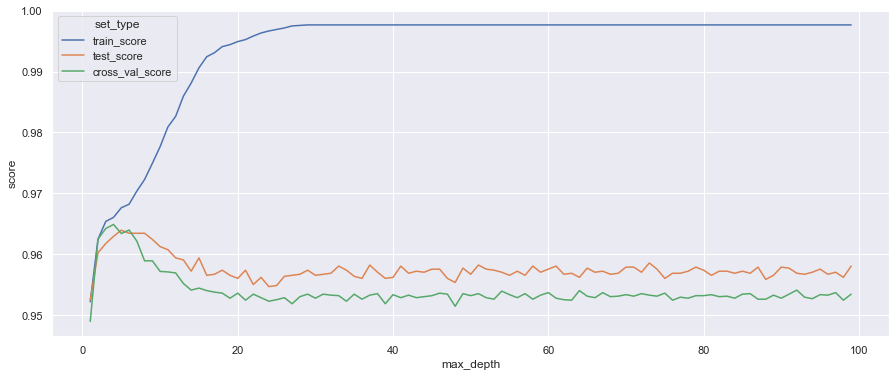

In [135]:
sns.lineplot(x= 'max_depth', y = 'score', hue='set_type', data=scores_data_long )

In [136]:
scores_data_long.query("set_type=='cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.948958
199,2,cross_val_score,0.962486
200,3,cross_val_score,0.964229
201,4,cross_val_score,0.964893
202,5,cross_val_score,0.963399
203,6,cross_val_score,0.963980
204,7,cross_val_score,0.962154
205,8,cross_val_score,0.958918
206,9,cross_val_score,0.958918
207,10,cross_val_score,0.957175


На основании данной таблицы мы узнали, что наилучший параметр достигается при max_depth= 4. Его и передадим в лучший классификатор best_clf

In [154]:
best_clf=tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
best_clf.fit(X_train, y_train)
print(best_clf.score(X_train,y_train), best_clf.score(X_test,y_test))


0.9655963302752294 0.9641367806505421


In [139]:
##### GridSearch Grid Search

In [155]:
parametrs={'criterion':['gini', 'entropy'], 'max_depth': range(1, 30)
           #, 'min_samples_leaf': [2]
          }

In [156]:
clf=tree.DecisionTreeClassifier()

In [157]:
grid_search_cv_clf=GridSearchCV(clf, parametrs, cv=4
                                #, n_jobs=-1
                               )
grid_search_cv_clf.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [158]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [159]:
best_clf=grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=4)

In [160]:
best_clf.score(X_test, y_test)

0.9652488184598277

In [161]:
y_pred= best_clf.predict(X_test)

In [162]:
precision_score(y_test, y_pred)

0.6773162939297125

In [163]:
recall_score(y_test, y_pred)

0.8983050847457628

In [164]:
print(cross_val_score(best_clf,X_train,y_train,cv=5).mean())

0.9630250509480307


##### Чужие решения

In [150]:
%%time
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

clf = LogisticRegressionCV(cv=5)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.coef_)
print(clf.intercept_)
print(cross_val_score(clf,X_train,y_train,cv=4).mean())

 


0.9624687239366139
[[ 0.04479623  0.03045396  0.04429845 -0.01496597  0.0360713   0.0090006 ]]
[-4.82989714]
0.955240478176258
Wall time: 6.44 s


In [151]:
%%time
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=4)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())


{'max_depth': 4, 'max_leaf_nodes': 14, 'min_samples_leaf': 3, 'min_samples_split': 2} 0.9629552404781763
Wall time: 7.74 s


In [152]:
%%time
 

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 20} 0.9636502641089797
Wall time: 27.4 s


In [153]:
import statsmodels.api as sm
logit = sm.Logit(y_train.reset_index().drop('index', axis=1), sm.add_constant(X_train).reset_index().drop('user_id', axis=1))
logit = logit.fit(method='newton')
logit.summary()



Optimization terminated successfully.
         Current function value: 0.122144
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          passed_course   No. Observations:                14388
Model:                          Logit   Df Residuals:                    14381
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5717
Time:                        01:24:35   Log-Likelihood:                -1757.4
converged:                       True   LL-Null:                       -4103.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.4716      0.128    -42.726      0.000      -5.723      -5.221
days              0.0416      0.061      0.678      0.498      -0.079       0.162
steps_tried   -6.406e-05      0.050     -0.001      0.999      -0.099       0.099
correct           0.0700      0.050      1.413      0.158      -0.027       0.167
wrong            -0.0073      0.004     -1.979      0.048      -0.015    -6.9e-05
correct_ratio     0.9531      0.160      5.960      0.000       0.640       1.267
viewed            0.0096      0.000     37.297      0.000       0.009       0.010
=================================================================================
"""